In [1]:
import os

In [2]:
os.chdir('../..')

In [3]:
import convokit
from convokit import Corpus, download, TriadMotif
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
corpus = Corpus(filename=download('reddit-corpus'))

Dataset already exists at /Users/calebchiam/.convokit/downloads/reddit-corpus


In [5]:
corpus.print_summary_stats()

Number of Users: 521777
Number of Utterances: 2004262
Number of Conversations: 84979


In [6]:
hc = convokit.HyperConvo(prefix_len=10, min_thread_len=10, include_root=False)

In [7]:
motif_paths = hc.retrieve_motif_paths(corpus)

In [8]:
print("Number of threads:", len(motif_paths))

Number of threads: 100000


In [9]:
all_paths = {k: list() for k in TriadMotif.paths_list()}

In [10]:
print("Number of unique paths", len(all_paths))

Number of unique paths 100


In [11]:
for thread, path_dict in motif_paths.items():
    for path_type, instances in path_dict.items():
        all_paths[path_type].extend(instances)

As we are only focusing on cases when C joins a reciprocal interaction, we can filter the all_paths dict to those paths we actually care about:
- Path has a dyadic interaction forming first (i.e. contains DYADIC_TRIADS stage)
- C joins the conversation by responding to A or B (i.e. if the interaction proceeds beyond dyadic, it must goes to the INCOMING_1TO3_TRIADS stage and not the OUTGOING_3TO1_TRIADS stage)

In [12]:
relevant_path_types = dict()
for path_type, instances in all_paths.items():
    if 'DYADIC_TRIADS' in path_type and 'OUTGOING_3TO1_TRIADS' not in path_type:
        relevant_path_types[path_type] = instances
        print("{}: {}".format(path_type, len(instances)))

('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'DYADIC_TRIADS'): 200518
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'DYADIC_TRIADS', 'INCOMING_1TO3_TRIADS'): 119932
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'DYADIC_TRIADS', 'INCOMING_1TO3_TRIADS', 'DIRECIPROCAL_TRIADS'): 50833
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'DYADIC_TRIADS', 'INCOMING_1TO3_TRIADS', 'DIRECIPROCAL_TRIADS', 'DIRECIPROCAL_2TO3_TRIADS'): 400
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'DYADIC_TRIADS', 'INCOMING_1TO3_TRIADS', 'DIRECIPROCAL_TRIADS', 'DIRECIPROCAL_2TO3_TRIADS', 'TRIRECIPROCAL_TRIADS'): 21
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'DYADIC_TRIADS', 'INCOMING_1TO3_TRIADS', 'DIRECTED_CYCLE_1TO3_TRIADS'): 1142
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'DYADIC_TRIADS', 'INCOMING_1TO3_TRIADS', 'DIRECTED_CYCLE_1TO3_TRIADS', 'DIRECIPROCAL_2TO3_TRIADS'): 641
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'DYADIC_TRIADS', 'INCOMING_1TO3_TRIADS', 'DIRECTED_CYCLE_1TO3_TRIADS', 'DIRECIPROCAL_2TO3_TRIADS', 'TRIRECIPROCAL_TRIADS'): 11
('

Now we want to segment our analysis by the density of the A<->B interaction, where density is the number of utterances between A and B **before C joins the conversation (if at all)**. The minimum density value is 2.

We can imagine a distribution for each density value: for the motifs with reciprocal density x, we have 3 cases: C does not respond, C responds to A (the user first being responded to in the reciprocal interaction) or C or C responds to B (the other user in the reciprocal interaction.)

We define a function that computes the density of the reciprocal interaction -- the function is defined with the assumption that the motif regresses to a dyadic state, and is not generalizable to all motifs.

In [13]:
motif = relevant_path_types[('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'DYADIC_TRIADS', 'INCOMING_1TO3_TRIADS')][0]

In [14]:
motif.regress().edges

([{'timestamp': 1507050632,
   'text': 'Are you proud of that?',
   'speaker': User([('name', 'Averagegamer613')]),
   'target': User([('name', 'pfabs')]),
   'reply_to': 'dnursyi',
   'top_level_comment': '7400vr',
   'utt_id': 'dnusil5',
   'root': False}],
 [{'timestamp': 1507050852,
   'text': "No. I just don't understand people that are sick so often that they constantly call out. ",
   'speaker': User([('name', 'pfabs')]),
   'target': User([('name', 'Averagegamer613')]),
   'reply_to': 'dnusil5',
   'top_level_comment': '7400vr',
   'utt_id': 'dnusq9k',
   'root': False}])

In [15]:
## 
def identify_user_in_dyadic(motif, target_username):
    assert motif.get_type() == 'DYADIC_TRIADS'
    # By default, based on structure, user C will have engaged with the 2nd user
    edges_1_time = motif.edges[0][0]['timestamp']
    edges_2_time = motif.edges[1][0]['timestamp']
    users = [e[0]['speaker'] for e in motif.edges]
    
    if edges_1_time < edges_2_time:  # the first utt in the chain was made by User 1, i.e. User 1 is B, User 2 is A
        return 'A'
    else:
        return 'B'

def get_reciprocal_density(motif, before_time=None):
    assert motif.get_type() == 'DYADIC_TRIADS'
    density = 0
    if before_time is None: return sum([len(e) for e in motif.edges])
        
    for edge_set in motif.edges:
        for edge in edge_set:
            if edge['timestamp'] < before_time:
                density += 1
    return density
                
def compute_reciprocal_density(motif):
    """
    assumes: motif contains DYADIC and possibly INCOMING_1TO3
    map the motif to (eventual motif type, density of A<->B interaction just before C enters, if C responds to A/B)
    If C does not enter, return the current motif type and the density of the A<->B interaction
    """
    final_type = motif.get_type()
    
    if final_type == 'DYADIC_TRIADS':
        density = get_reciprocal_density(motif)
        responds_to = 'nil'
    else:
        while motif.get_type() != 'INCOMING_1TO3_TRIADS':
            motif = motif.regress()
        first_C_edge = motif.edges[0][0]
        motif = motif.regress() # now at the dyadic stage
        responds_to = identify_user_in_dyadic(motif, first_C_edge['target'].name)
        density = get_reciprocal_density(motif, before_time=first_C_edge['timestamp'])
    
    return (final_type, density, responds_to)
    

In [16]:
relevant_instances = []
for path_type, instances in relevant_path_types.items():
    relevant_instances.extend(instances)

In [17]:
len(relevant_instances)

375268

In [18]:
data = [compute_reciprocal_density(motif) for motif in relevant_instances]

In [19]:
import pandas as pd

In [20]:
df = pd.DataFrame(data=data, columns=['final_type', 'density', 'responds_to'])

In [21]:

Counter(df['density'])

Counter({2: 271789, 3: 65879, 4: 23512, 5: 8515, 6: 3637, 7: 1438, 8: 498})

In [22]:
Counter(df[df['density'] == 2]['responds_to'])

Counter({'nil': 152605, 'A': 91134, 'B': 28050})

In [23]:
df.head()

,final_type,density,responds_to
0,DYADIC_TRIADS,2,nil
1,DYADIC_TRIADS,2,nil
2,DYADIC_TRIADS,3,nil
3,DYADIC_TRIADS,3,nil
4,DYADIC_TRIADS,2,nil


## Distribution of responds_to for each density for each motif

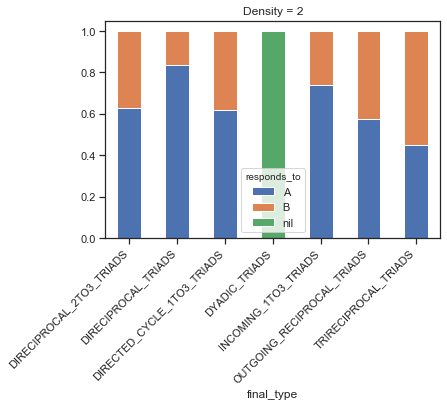

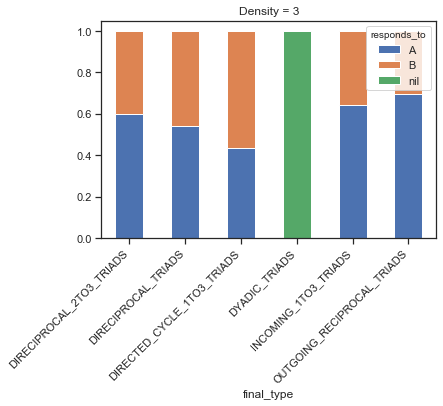

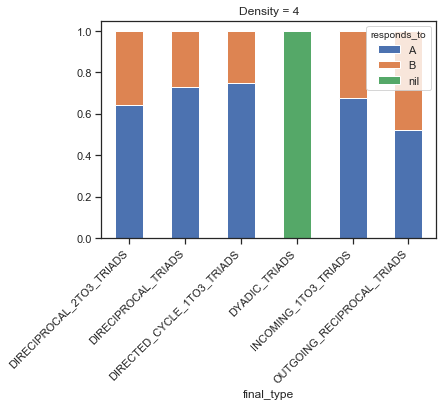

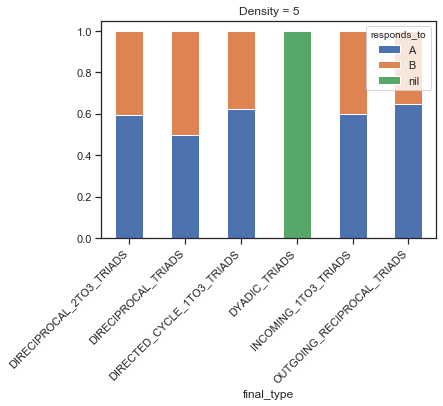

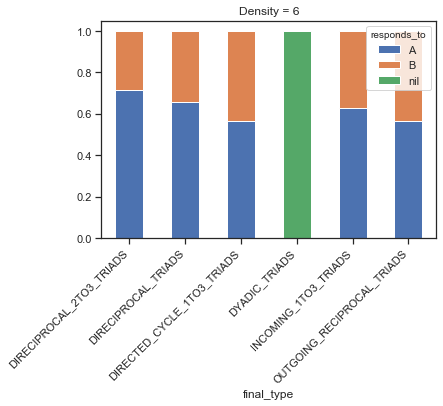

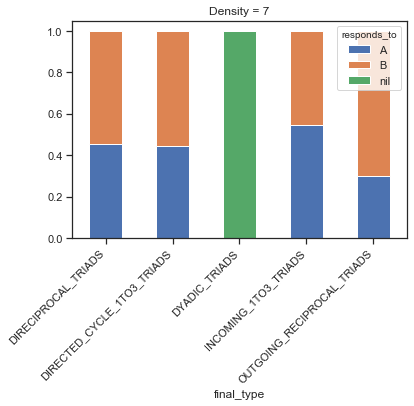

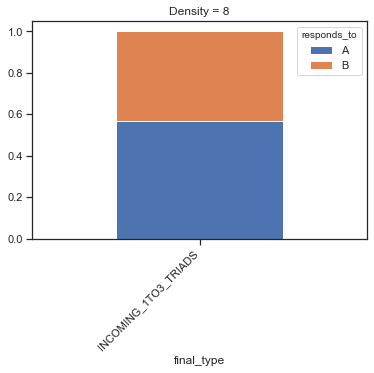

In [25]:
for i in Counter(df['density']).keys():
    props = df[df['density']==i].groupby("final_type")['responds_to'].value_counts(normalize=True).unstack()
    props.plot(kind='bar', stacked='True')
    plt.title("Density = {}".format(i))
    plt.xticks(rotation=45, horizontalalignment='right')

## Overall response-to distribution for each density (ignoring motif type)

In [107]:
grouped_by_density = df.groupby('density')['responds_to'].value_counts(normalize=True).unstack()

In [108]:
grouped_by_density

responds_to,A,B,nil
density,,,
2,0.335312,0.103205,0.561483
3,0.307124,0.195009,0.497867
4,0.390056,0.173231,0.436713
5,0.342924,0.264122,0.392954
6,0.441023,0.251581,0.307396
7,0.376912,0.357441,0.265647
8,0.568273,0.431727,NaN


In [110]:
grouped_by_density.mean()

responds_to
A      0.394518
B      0.253759
nil    0.410343
dtype: float64

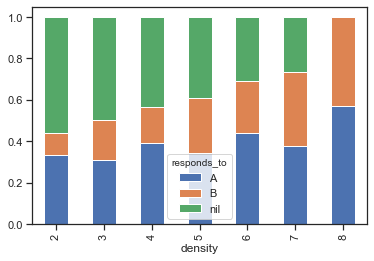

In [115]:
grouped_by_density.plot(kind='bar', stacked=True)

## Raw count distribution of response_to for different motif types, row-ordered by density

Ordered rows for density = 2 to density = 8


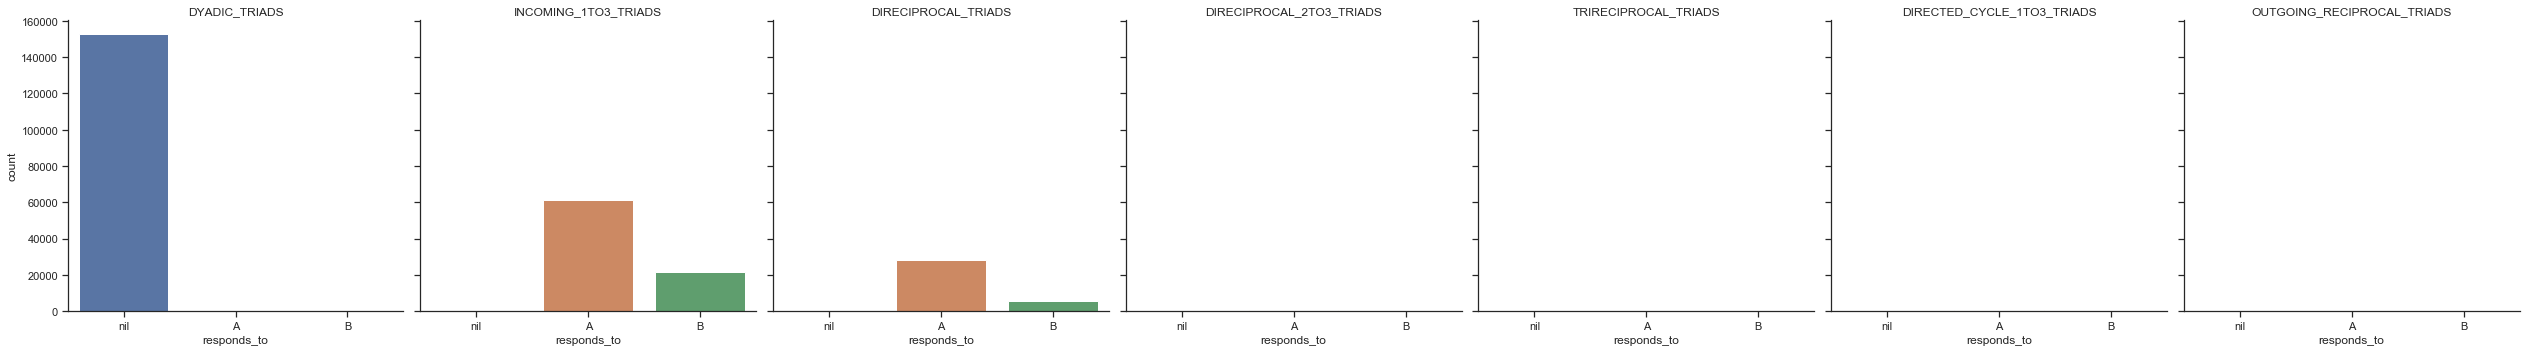

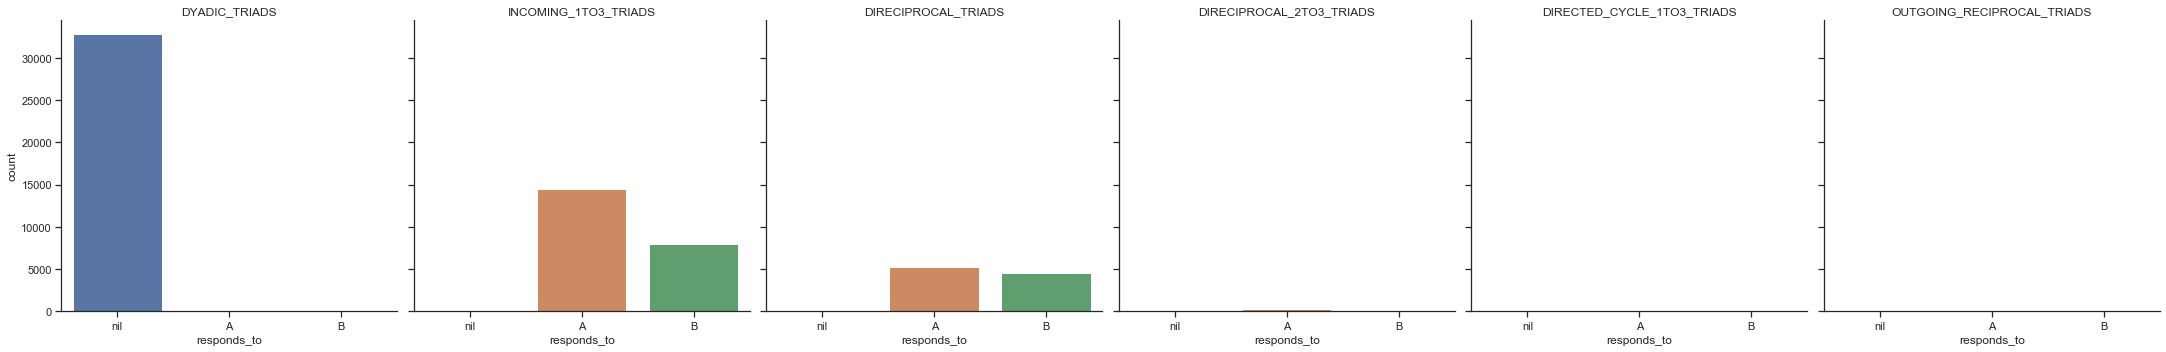

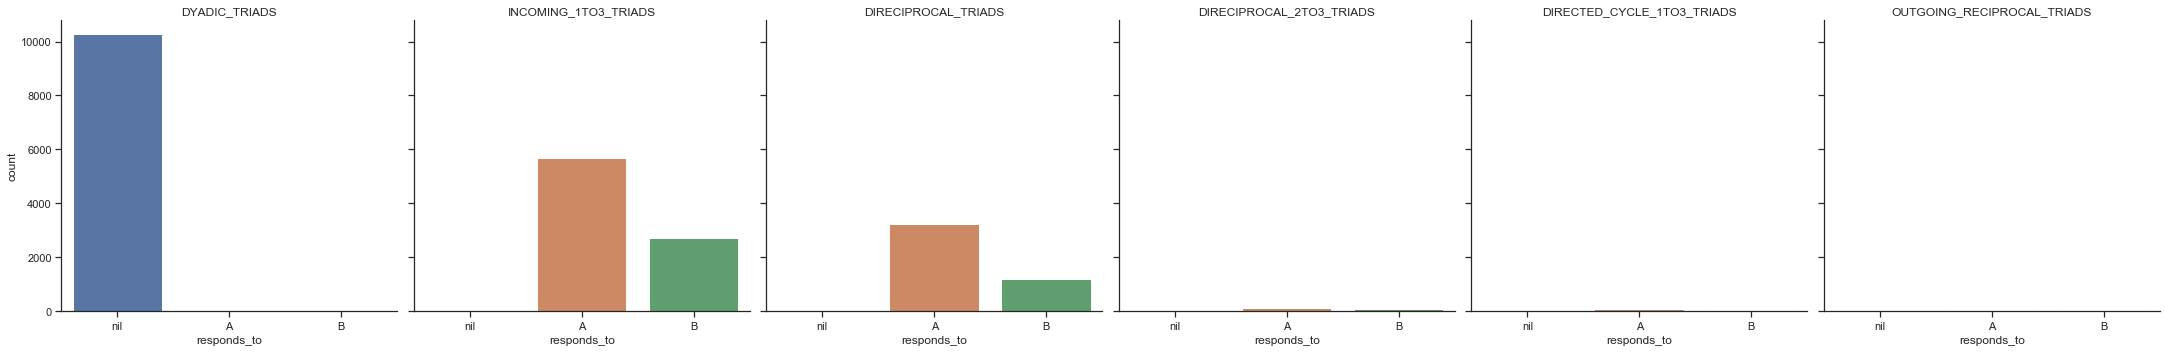

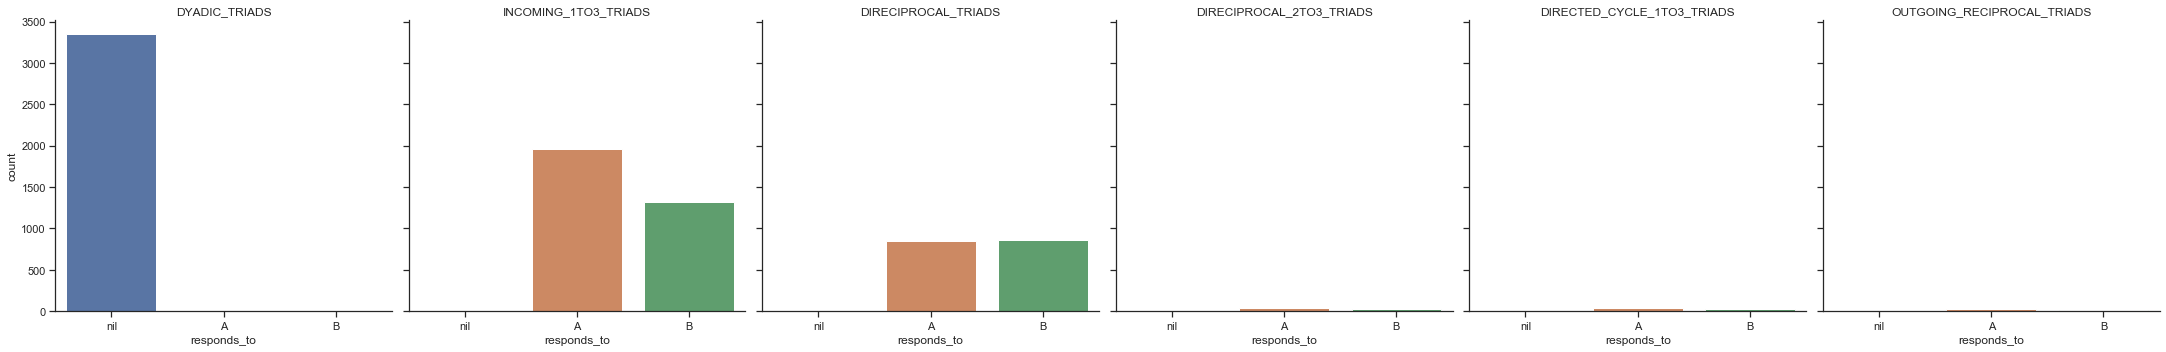

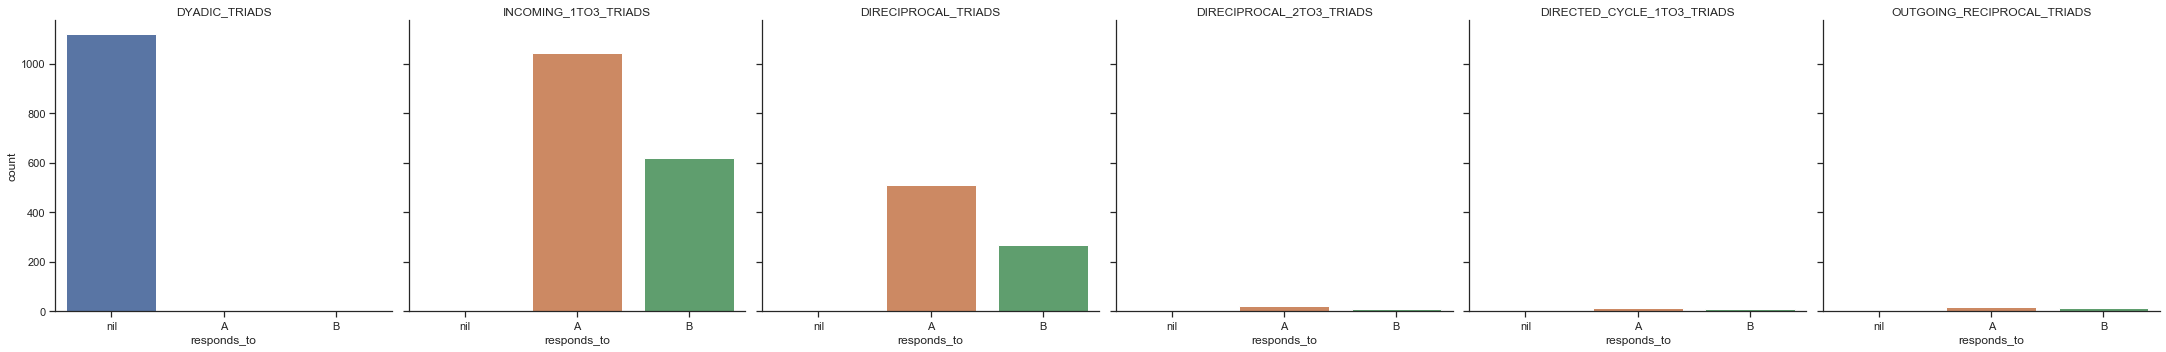

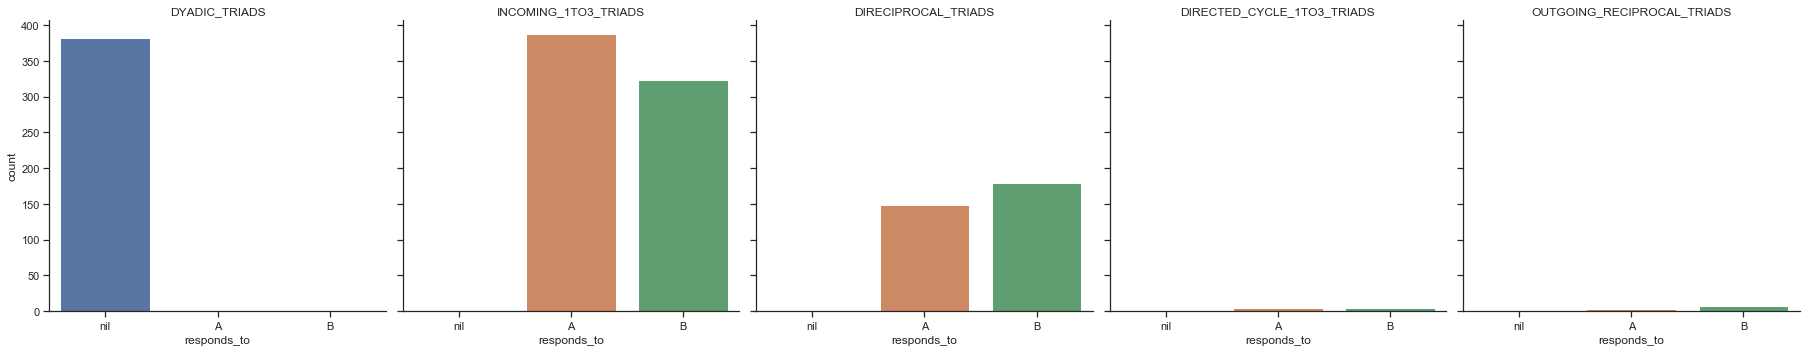

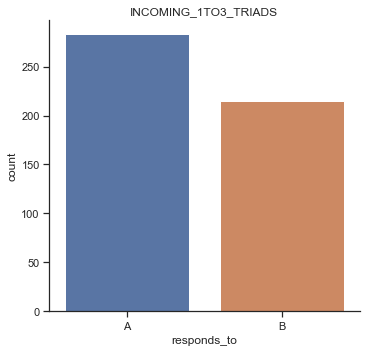

In [27]:
for i in Counter(df['density']).keys():
    ax = sns.catplot("responds_to", data=df[df['density'] == i], col="final_type", kind="count").set_titles("{col_name}")
    
print("Ordered rows for density = 2 to density = 8")

In [33]:
dfs_normalized_grouped = [df[df['density']==i].groupby("final_type")['responds_to'].value_counts(normalize=True).unstack() for i in Counter(df['density']).keys()]

In [35]:
len(dfs_normalized_grouped)

7

In [41]:
for idx, sub_df in enumerate(dfs_normalized_grouped):
    sub_df['density'] = idx + 2

In [42]:
df_all_normalized = pd.concat(dfs_normalized_grouped, sort=False)

In [49]:
df_all_normalized.head().index

Index(['DIRECIPROCAL_2TO3_TRIADS', 'DIRECIPROCAL_TRIADS',
       'DIRECTED_CYCLE_1TO3_TRIADS', 'DYADIC_TRIADS', 'INCOMING_1TO3_TRIADS'],
      dtype='object', name='final_type')

In [54]:
final_types = list(set(df_all_normalized.index))

In [55]:
final_types

['DIRECTED_CYCLE_1TO3_TRIADS',
 'INCOMING_1TO3_TRIADS',
 'OUTGOING_RECIPROCAL_TRIADS',
 'DYADIC_TRIADS',
 'TRIRECIPROCAL_TRIADS',
 'DIRECIPROCAL_2TO3_TRIADS',
 'DIRECIPROCAL_TRIADS']

## For each final type, what is the distribution of responses to A / B for each density?

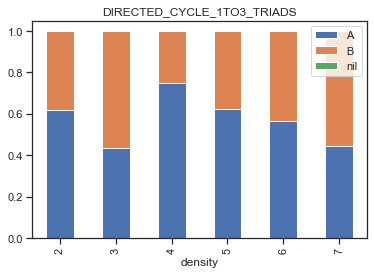

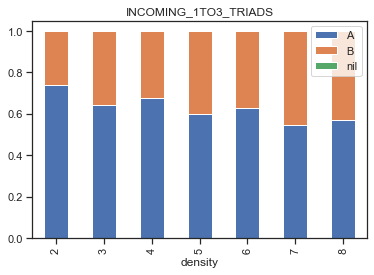

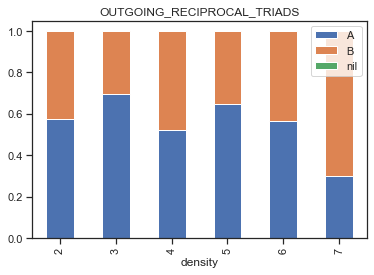

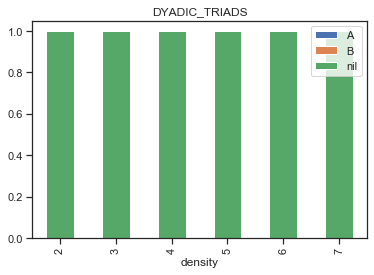

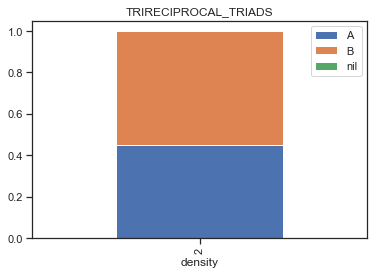

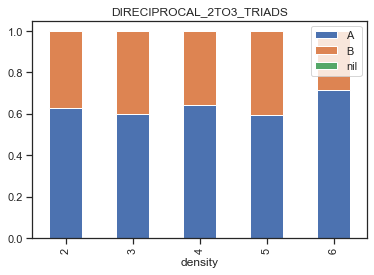

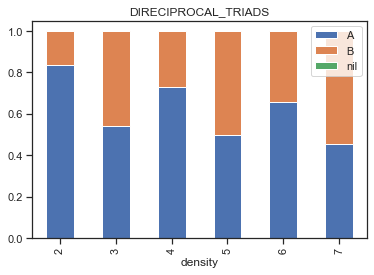

In [72]:
for final_t in final_types:
    d = df_all_normalized[df_all_normalized.index == final_t]
    d.index = d['density']
    del d['density']
    d.plot(kind="bar", stacked=True).set_title(final_t)